In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

!pwd
os.chdir("../data")
path="train.parquet"
cluster_path = "steam_data_clustered.parquet"

/Users/isaac/Documents/GitHub/SteamStore-ANALYSE/EDA


In [2]:
df = pd.read_parquet(path)
cluster = pd.read_parquet(cluster_path)

In [3]:
# Merge
df = pd.merge(df, cluster, on="app_id")

# description_courte
df = df.drop(columns=["description_courte_y"])
df = df.rename(columns={"description_courte_x": "description_courte"})

# tags_utilisateurs
df = df.drop(columns=["tags_utilisateurs_y"])
df = df.rename(columns={"tags_utilisateurs_x": "tags_utilisateurs"})
df["description_courte"] = df["description_courte"].astype(str)

df = df.loc[:, ~df.columns.duplicated()]
assert not df.columns.duplicated().any()
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df = df.loc[:, ~df.columns.str.startswith('emb')]
df = df.loc[:, ~df.columns.str.startswith('configuration')]

df["log_review"] = np.log1p(df["review"])
del cluster

In [4]:
df["plateformes"]

0             [windows]
1             [windows]
2             [windows]
3             [windows]
4             [windows]
              ...      
45933         [windows]
45934    [windows, mac]
45935         [windows]
45936         [windows]
45937         [windows]
Name: plateformes, Length: 45938, dtype: object

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_65976/160104178.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


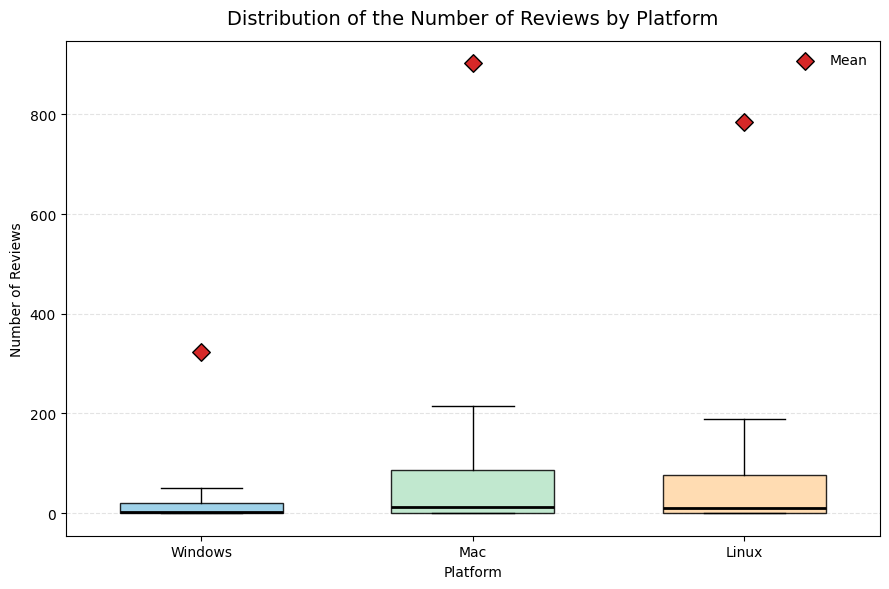

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data preparation
df_plot = df[['review', 'plateformes']].copy()
df_plot = df_plot.explode('plateformes')
df_plot['plateformes'] = df_plot['plateformes'].str.capitalize()

platforms = ['Windows', 'Mac', 'Linux']
df_plot = df_plot[df_plot['plateformes'].isin(platforms)]

# Data per platform (controlled order)
data = [df_plot[df_plot['plateformes'] == p]['review'] for p in platforms]

# Means
means = [d.mean() for d in data]

plt.figure(figsize=(9,6))

# Matplotlib boxplot (fully stylable)
bp = plt.boxplot(
    data,
    labels=platforms,
    showfliers=False,
    widths=0.6,
    patch_artist=True
)

# Pastel color palette
colors = ['#8ecae6', '#b7e4c7', '#ffd6a5']  # blue / green / orange
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.85)

# Make medians more visible
for median in bp['medians']:
    median.set(color='black', linewidth=2)

# Mean points
x_positions = np.arange(1, len(platforms) + 1)
plt.scatter(
    x_positions,
    means,
    s=80,
    marker='D',
    color='#d62828',
    edgecolor='black',
    zorder=3,
    label='Mean'
)

# Formatting
plt.title("Distribution of the Number of Reviews by Platform", fontsize=14, pad=12)
plt.xlabel("Platform")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

In [6]:
from scipy.stats import f_oneway
from scipy.stats import kruskal
# Data per platform
windows = df_plot[df_plot['plateformes'] == 'Windows']['review']
mac     = df_plot[df_plot['plateformes'] == 'Mac']['review']
linux   = df_plot[df_plot['plateformes'] == 'Linux']['review']

# One-way ANOVA
f_stat, p_value = f_oneway(windows, mac, linux)

print("One-way ANOVA results")
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_value:.4e}")
h_stat, p_value = kruskal(windows, mac, linux)
print()
print("Kruskal–Wallis test results")
print(f"H-statistic: {h_stat:.3f}")
print(f"p-value: {p_value:.4e}")

One-way ANOVA results
F-statistic: 27.479
p-value: 1.1780e-12

Kruskal–Wallis test results
H-statistic: 2087.402
p-value: 0.0000e+00


In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Data already exploded (df_plot)
tukey = pairwise_tukeyhsd(
    endog=df_plot['review'],
    groups=df_plot['plateformes'],
    alpha=0.05
)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1  group2  meandiff p-adj    lower     upper   reject
----------------------------------------------------------
 Linux     Mac  117.4284 0.6138 -174.8077  409.6645  False
 Linux Windows -461.3043    0.0 -698.7136  -223.895   True
   Mac Windows -578.7327    0.0  -788.472 -368.9933   True
----------------------------------------------------------


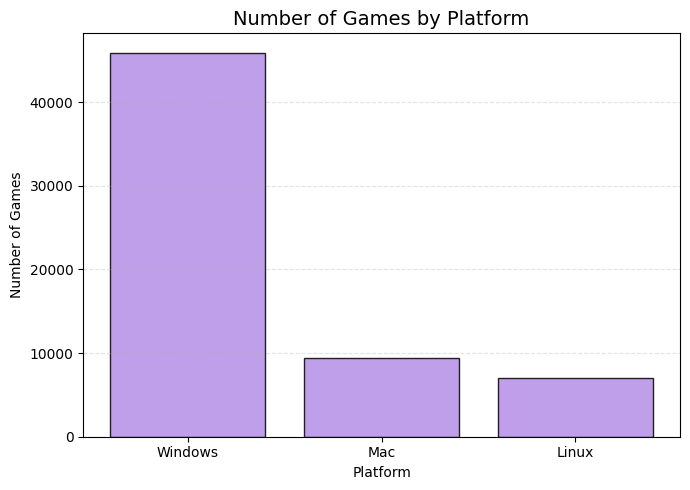

In [ ]:

df_platform = df[['plateformes']].copy()
df_platform = df_platform.explode('plateformes')
df_platform['plateformes'] = df_platform['plateformes'].str.capitalize()

# Count games per platform
platform_counts = df_platform['plateformes'].value_counts().reindex(
    ['Windows', 'Mac', 'Linux']
)

# Plot
plt.figure(figsize=(7,5))
plt.bar(
    platform_counts.index,
    platform_counts.values,
    color="#b48ee6",        # pastel
    edgecolor='black',
    alpha=0.85
)

plt.title("Number of Games by Platform", fontsize=14)
plt.xlabel("Platform")
plt.ylabel("Number of Games")
plt.grid(axis='y', linestyle='--', alpha=0.35)

plt.tight_layout()
plt.show()

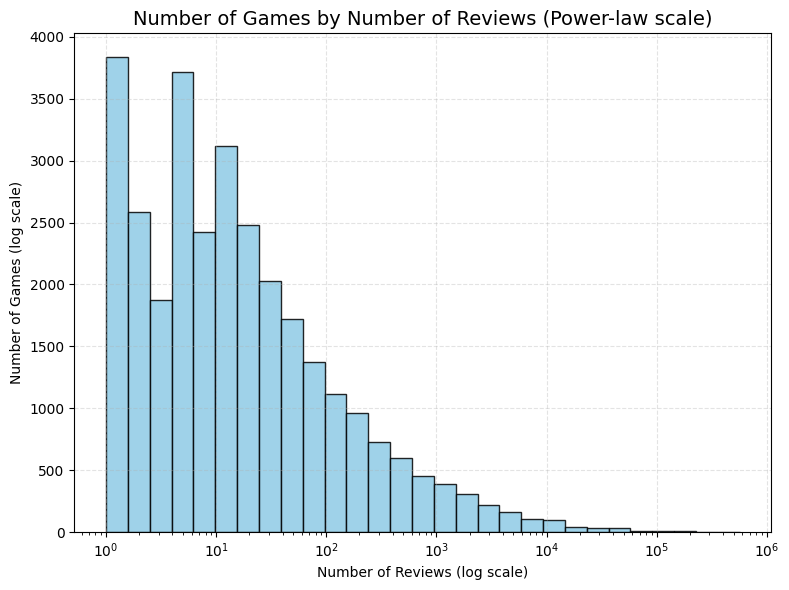

In [9]:
# Définir des bins log-spaced pour capturer la loi de puissance
bins = np.logspace(0, np.log10(df['review'].max() + 1), 30)

plt.figure(figsize=(8,6))
plt.hist(df['review'], bins=bins, color='#8ecae6', edgecolor='black', alpha=0.85)

plt.xscale('log')  # logarithmic x-axis
#plt.yscale('log')  # logarithmic y-axis pour mieux visualiser la loi de puissance

plt.title("Number of Games by Number of Reviews (Power-law scale)", fontsize=14)
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Number of Games (log scale)")
plt.grid(True, linestyle='--', alpha=0.35)

plt.tight_layout()
plt.show()

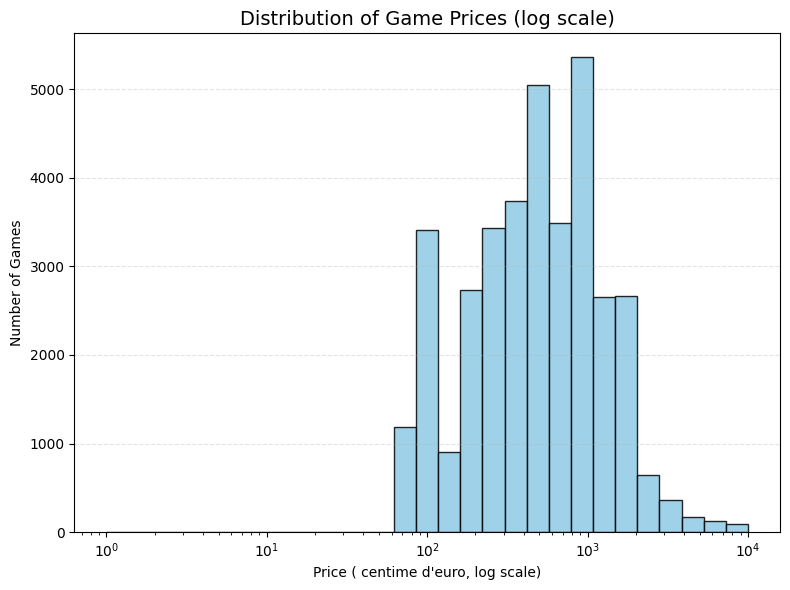

In [10]:
plt.figure(figsize=(8,6))

plt.hist(df['prix'], bins=np.logspace(0, np.log10(df['prix'].max()+1), 30),
         color='#8ecae6', edgecolor='black', alpha=0.85)
plt.xscale('log')  # rend la distribution lisible
plt.title("Distribution of Game Prices (log scale)", fontsize=14)
plt.xlabel("Price ( centime d'euro, log scale)")
plt.ylabel("Number of Games")
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

In [ ]:
df['prix'] = df['prix'] / 100

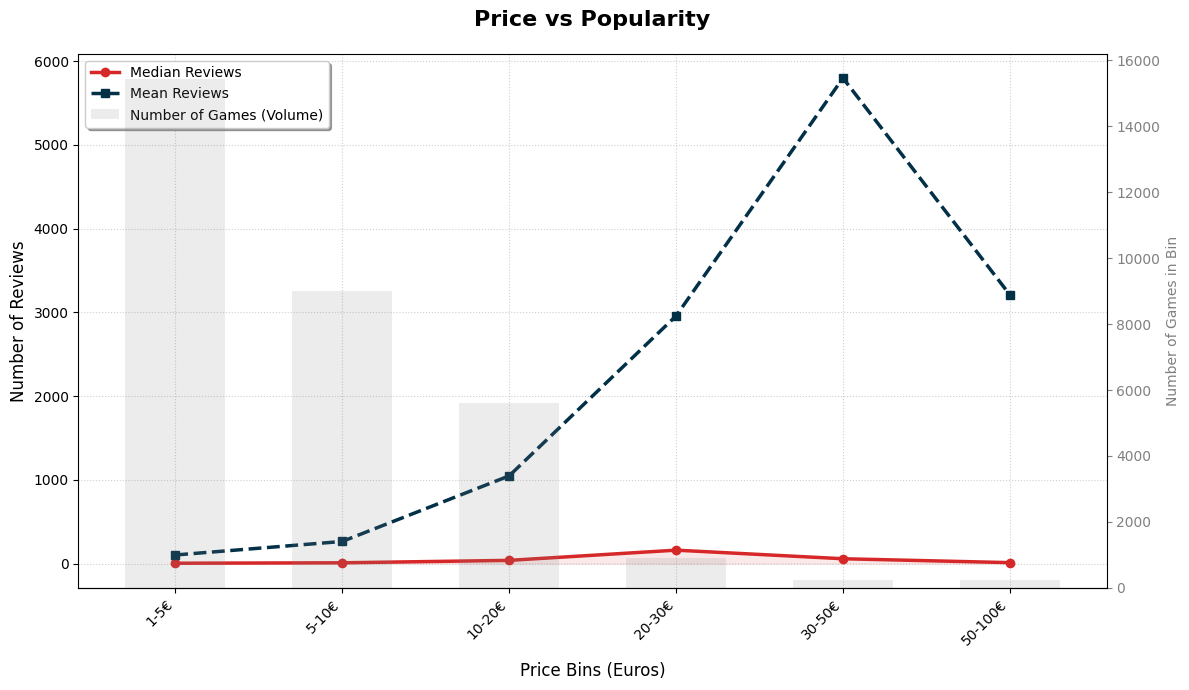

In [14]:

max_val = df['prix'].max()
bins_edges = np.array([1, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000])

# Ajout du max pour fermer le dernier bin si nécessaire
if max_val > bins_edges[-1]:
    bins_edges = np.append(bins_edges, max_val + 1)

df['price_bin'] = pd.cut(df['prix'], bins=bins_edges)

# Calcul des stats
grouped = df.groupby('price_bin', observed=True)['review'].agg(['mean', 'median', 'count']).reset_index()

# 3. Création des Labels "Propres" en Euros
x_labels = []
for interval in grouped['price_bin']:
    # CORRECTION ICI : Ne pas diviser par 100, car c'est déjà en Euros
    left_eur = int(interval.left)
    right_eur = int(interval.right)
    
    # Gestion du dernier bin pour affichage "1000€+" si besoin
    # On compare avec max_val (qui est déjà en Euros)
    if right_eur > 1000 and interval.right >= max_val: 
         x_labels.append(f"> {left_eur}€")
    else:
        x_labels.append(f"{left_eur}-{right_eur}€")

x_pos = range(len(grouped))

# 4. Le Plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Arrière-plan : Histogramme du nombre de produits (Volume) ---
ax2 = ax1.twinx()
ax2.bar(x_pos, grouped['count'], color='gray', alpha=0.15, width=0.6, label='Number of Games (Volume)')
ax2.set_ylabel('Number of Games in Bin', color='gray', fontsize=10)
ax2.tick_params(axis='y', colors='gray')
ax2.grid(False)  # Hide grid for secondary axis to avoid clutter

# --- Foreground: Mean and Median curves ---
ax1.plot(x_pos, grouped['median'], color='#d62828', marker='o', markersize=6, 
         linewidth=2.5, label='Median Reviews')
ax1.plot(x_pos, grouped['mean'], color='#023047', marker='s', markersize=6, 
         linewidth=2.5, linestyle='--', label='Mean Reviews')

ax1.fill_between(x_pos, grouped['median'], alpha=0.1, color='#d62828')

# --- Mise en forme ---
# --- Formatting ---
ax1.set_title("Price vs Popularity", fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel("Price Bins (Euros)", fontsize=12, labelpad=10)
ax1.set_ylabel("Number of Reviews", fontsize=12)

# Configuration de l'axe X
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

# Grille et esthétique
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

In [12]:
df["prix"]

0        19.99
1         1.99
2         0.00
3         6.59
4         4.99
         ...  
45933    15.99
45934     7.79
45935     1.99
45936    12.99
45937     9.75
Name: prix, Length: 45938, dtype: float64

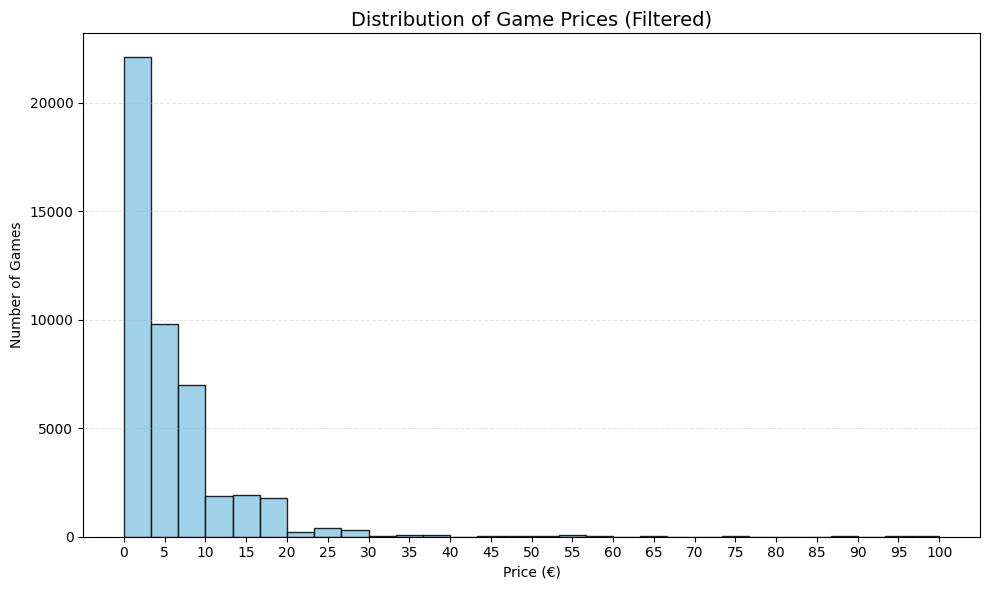

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Filtrer les prix extrêmes (ex: garder seulement < 100€)
df_clean = df

plt.figure(figsize=(10,6))
plt.hist(df_clean['prix'], bins=30, color='#8ecae6', edgecolor='black', alpha=0.85)

plt.title("Distribution of Game Prices (Filtered)", fontsize=14)
plt.xlabel("Price (€)")
plt.ylabel("Number of Games")
plt.grid(axis='y', linestyle='--', alpha=0.35)

# Ajouter plus de ticks sur l'axe x (ex: tous les 5€)
ticks = np.arange(0, df_clean['prix'].max() + 5, 5)
plt.xticks(ticks)

plt.tight_layout()
plt.show()